In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from utils import *
from data_loader import load_data
import seaborn as sns

## Load data

In [2]:
final_clean_strained = load_data(db_level=0)

final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB)'] >= 70]
final_clean_strained_80 = final_clean_strained[final_clean_strained['Level(dB)'] == 80]

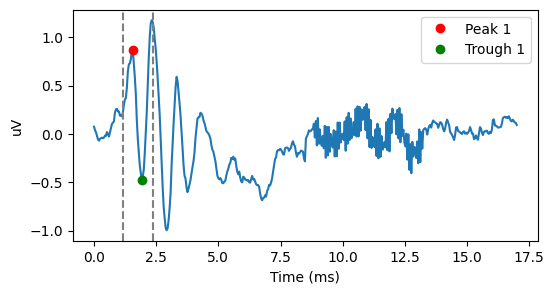

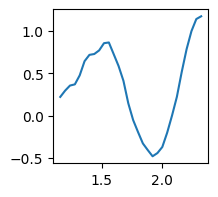

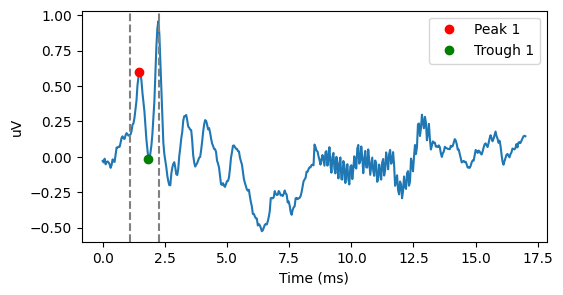

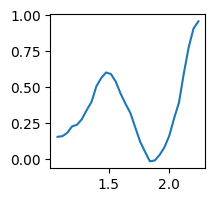

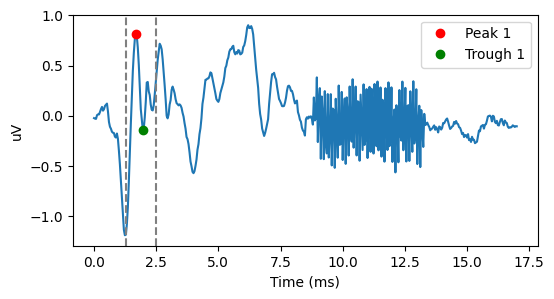

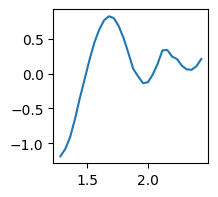

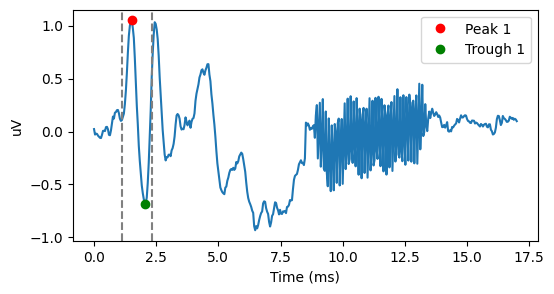

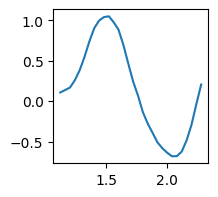

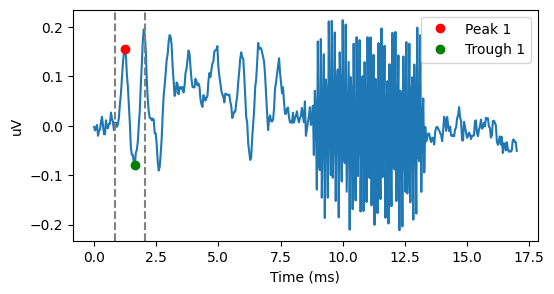

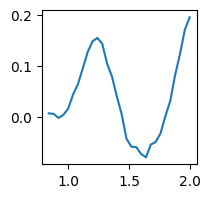

In [14]:
# choose random 5 samples to plot:
random_samples = final_clean_strained_80.sample(n=5, random_state=10)
for idx, sample in random_samples.iterrows():
    plt.figure(figsize=(6,3))
    x = np.linspace(0,17, len(sample['Waveform']))
    plt.plot(x, sample['Waveform'])
    plt.plot(x[sample['Peaks']][0], sample['Waveform'][sample['Peaks']][0], 'ro', label='Peak 1')
    plt.plot(x[sample['Troughs']][0], sample['Waveform'][sample['Troughs']][0], 'go', label='Trough 1')
    plt.axvline(x=x[sample['Peaks'][0]-10], linestyle='--', color='gray')
    plt.axvline(x=x[sample['Peaks'][0]+20], linestyle='--', color='gray')
    plt.xlabel('Time (ms)')
    plt.ylabel('uV')
    plt.legend()
    plt.show()
    plt.figure(figsize=(2,2))
    plt.plot(x[sample['Peaks'][0]-10:sample['Peaks'][0]+20], sample['WaveI'])
    plt.show()

## Control data - look at # synapses and amplitude vs freq, dB

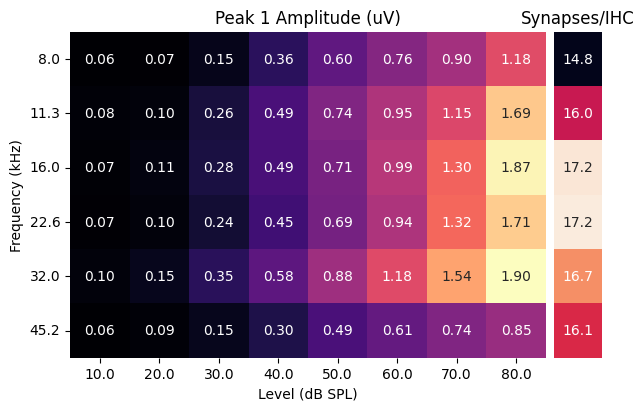

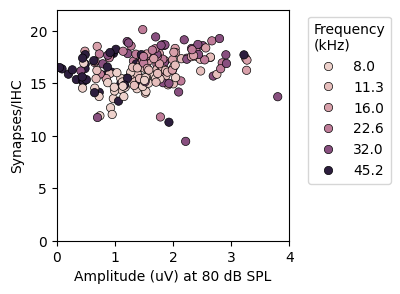

In [4]:
ctrls = final_clean_strained[final_clean_strained['Noise']==0]
ctrls = ctrls[ctrls['Level(dB)'] % 10 == 0]

ctrls = ctrls[['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()

hmap = ctrls[['Frequency(kHz)', 'Level(dB)', 'Amplitude']].groupby(['Frequency(kHz)', 'Level(dB)']).mean().reset_index().pivot(index="Frequency(kHz)", columns="Level(dB)", values="Amplitude")

fig = plt.figure(layout="constrained", figsize=(6, 4))
gs0 = fig.add_gridspec(1, 2, width_ratios=[5, .5])
ax_left = fig.add_subplot(gs0[0])
ax_right = fig.add_subplot(gs0[1])

sns.heatmap(hmap, annot=True, fmt='.2f', ax=ax_left, cmap='magma', cbar=False)
ax_left.set_xlabel('Level (dB SPL)')
ax_left.set_ylabel('Frequency(kHz)')

ax_left.set_title('Peak 1 Amplitude (uV)')
ax_left.set_yticklabels(ax_left.get_yticklabels(), rotation=0)

################# 
ctrls_80 = final_clean_strained_80[final_clean_strained_80['Noise']==0]
ctrls_80_avg = ctrls_80[['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()

hmap = ctrls_80.groupby(['Frequency(kHz)', 'Noise'])['SynapsesPerIHC'].mean().reset_index()

# Pivot to create matrix for heatmap
hmap = hmap.pivot(
    index='Frequency(kHz)', 
    columns='Noise', 
    values='SynapsesPerIHC'
)

yax_off = True
sns.heatmap(hmap, annot=True, fmt='.1f', ax=ax_right, cbar=False)#, cmap='magma', cbar_kws={'label': 'Average Synapses/IHC'})
ax_right.set_xlabel('')
ax_right.set_title('Synapses/IHC')
plt.xticks(rotation=45)
if yax_off:
    ax_right.set_yticks([])
    ax_right.set_ylabel('')
else:
    ax_right.set_yticklabels(ax_right.get_yticklabels(), rotation=0)
ax_right.set_xticks([])

plt.show()

plt.figure(figsize=(3, 3))
sns.scatterplot(data=ctrls_80_avg, x='Amplitude', y='SynapsesPerIHC', hue='Frequency(kHz)', edgecolor='black')
plt.xlabel('Amplitude (uV) at 80 dB SPL')
plt.ylabel('Synapses/IHC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Frequency\n(kHz)')
plt.ylim(0, 22)
plt.xlim(0,4)
plt.show()

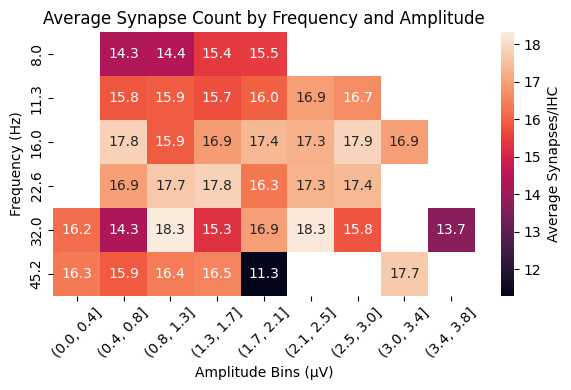

In [5]:
# Create amplitude bins
bins = np.linspace(final_clean_strained_80['Amplitude'].min(), final_clean_strained_80['Amplitude'].max(), 10) 
final_clean_strained_80['Amplitude_binned'] = pd.cut(
    final_clean_strained_80['Amplitude'], 
    bins=bins, 
    precision=1
)

ctrls = final_clean_strained_80[final_clean_strained_80['Noise']==0]

# Group by frequency and binned amplitude, calculate mean synapses
heatmap_data = ctrls.groupby(['Frequency(kHz)', 'Amplitude_binned'])['SynapsesPerIHC'].mean().reset_index()

# Pivot to create matrix for heatmap
heatmap_matrix = heatmap_data.pivot(
    index='Frequency(kHz)', 
    columns='Amplitude_binned', 
    values='SynapsesPerIHC'
)

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_matrix, annot=True, fmt='.1f', cbar='magma', cbar_kws={'label': 'Average Synapses/IHC'})
plt.title('Average Synapse Count by Frequency and Amplitude')
plt.xlabel('Amplitude Bins (µV)')
plt.ylabel('Frequency (Hz)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Noise exposure (>90 dB) data - trends in amplitude and synapse #

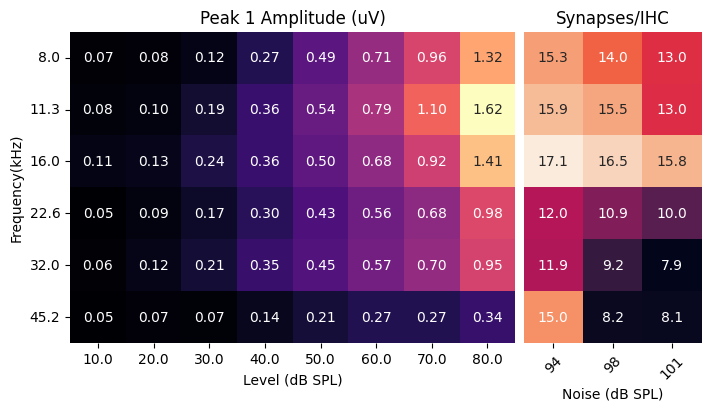

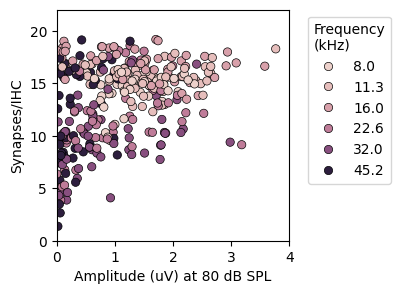

In [6]:
noise = final_clean_strained[final_clean_strained['Noise']>0.9]
noise = noise[noise['Level(dB)'] % 10 == 0]

noise = noise[['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()

hmap = noise[['Frequency(kHz)', 'Level(dB)', 'Amplitude']].groupby(['Frequency(kHz)', 'Level(dB)']).mean().reset_index().pivot(index="Frequency(kHz)", columns="Level(dB)", values="Amplitude")

fig = plt.figure(layout="constrained", figsize=(7, 4))
gs0 = fig.add_gridspec(1, 2, width_ratios=[5, 2])
ax_left = fig.add_subplot(gs0[0])
ax_right = fig.add_subplot(gs0[1])

sns.heatmap(hmap, annot=True, fmt='.2f', ax=ax_left, cmap='magma', cbar=False)
ax_left.set_xlabel('Level (dB SPL)')
ax_left.set_ylabel('Frequency(kHz)')

ax_left.set_title('Peak 1 Amplitude (uV)')
ax_left.set_yticklabels(ax_left.get_yticklabels(), rotation=0)

################# 
noise = final_clean_strained_80[final_clean_strained_80['Noise']>0.9]

hmap = noise.groupby(['Frequency(kHz)', 'Noise'])['SynapsesPerIHC'].mean().reset_index()

# Pivot to create matrix for heatmap
hmap = hmap.pivot(
    index='Frequency(kHz)', 
    columns='Noise', 
    values='SynapsesPerIHC'
)

# Create heatmap
yax_off = True
sns.heatmap(hmap, annot=True, fmt='.1f', ax=ax_right, cbar=False)
ax_right.set_xticklabels(['94', '98', '101'], rotation=0)
ax_right.set_xlabel('Noise (dB SPL)')
ax_right.set_title('Synapses/IHC')
plt.xticks(rotation=45)
ax_right.set_yticks([])
ax_right.set_ylabel('')

plt.show()

plt.figure(figsize=(3, 3))
noise_80 = noise[['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()
noise_80 = noise_80[noise_80['Level(dB)'] == 80]
sns.scatterplot(data=noise_80, x='Amplitude', y='SynapsesPerIHC', hue='Frequency(kHz)', edgecolor='black')
plt.xlabel('Amplitude (uV) at 80 dB SPL')
plt.ylabel('Synapses/IHC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Frequency\n(kHz)')
plt.ylim(0, 22)
plt.xlim(0,4)
plt.show()

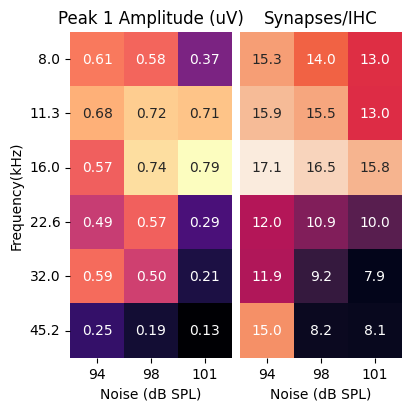

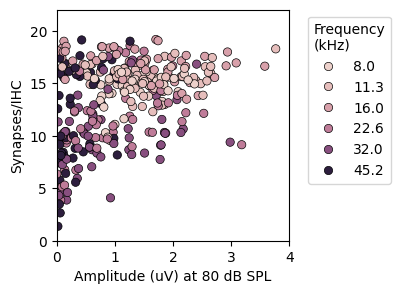

In [7]:
noise = final_clean_strained[final_clean_strained['Noise']>0.9]
noise = noise[noise['Level(dB)'] % 10 == 0]

noise = noise[['Subject', 'Frequency(kHz)', 'Noise', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()

hmap = noise[['Frequency(kHz)', 'Noise', 'Amplitude']].groupby(['Frequency(kHz)', 'Noise']).mean().reset_index().pivot(index="Frequency(kHz)", columns="Noise", values="Amplitude")

fig = plt.figure(layout="constrained", figsize=(4, 4))
gs0 = fig.add_gridspec(1, 2, width_ratios=[2, 2])
ax_left = fig.add_subplot(gs0[0])
ax_right = fig.add_subplot(gs0[1])

sns.heatmap(hmap, annot=True, fmt='.2f', ax=ax_left, cmap='magma', cbar=False)
ax_left.set_xlabel('Noise (dB SPL)')
ax_left.set_ylabel('Frequency(kHz)')

ax_left.set_title('Peak 1 Amplitude (uV)')
ax_left.set_yticklabels(ax_left.get_yticklabels(), rotation=0)
ax_left.set_xticklabels(['94', '98', '101'], rotation=0)


################# 
noise = final_clean_strained_80[final_clean_strained_80['Noise']>0.9]

hmap = noise.groupby(['Frequency(kHz)', 'Noise'])['SynapsesPerIHC'].mean().reset_index()

# Pivot to create matrix for heatmap
hmap = hmap.pivot(
    index='Frequency(kHz)', 
    columns='Noise', 
    values='SynapsesPerIHC'
)

# Create heatmap
yax_off = True
sns.heatmap(hmap, annot=True, fmt='.1f', ax=ax_right, cbar=False)
ax_right.set_xticklabels(['94', '98', '101'], rotation=0)
ax_right.set_xlabel('Noise (dB SPL)')
ax_right.set_title('Synapses/IHC')
ax_right.set_yticks([])
ax_right.set_ylabel('')

plt.show()

plt.figure(figsize=(3, 3))
noise_80 = noise[['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude', 'SynapsesPerIHC']].groupby(['Subject', 'Frequency(kHz)', 'Level(dB)']).mean().reset_index()
noise_80 = noise_80[noise_80['Level(dB)'] == 80]
sns.scatterplot(data=noise_80, x='Amplitude', y='SynapsesPerIHC', hue='Frequency(kHz)', edgecolor='black')
plt.xlabel('Amplitude (uV) at 80 dB SPL')
plt.ylabel('Synapses/IHC')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Frequency\n(kHz)')
plt.ylim(0, 22)
plt.xlim(0,4)
plt.show()

### Are the very low amplitudes correct?

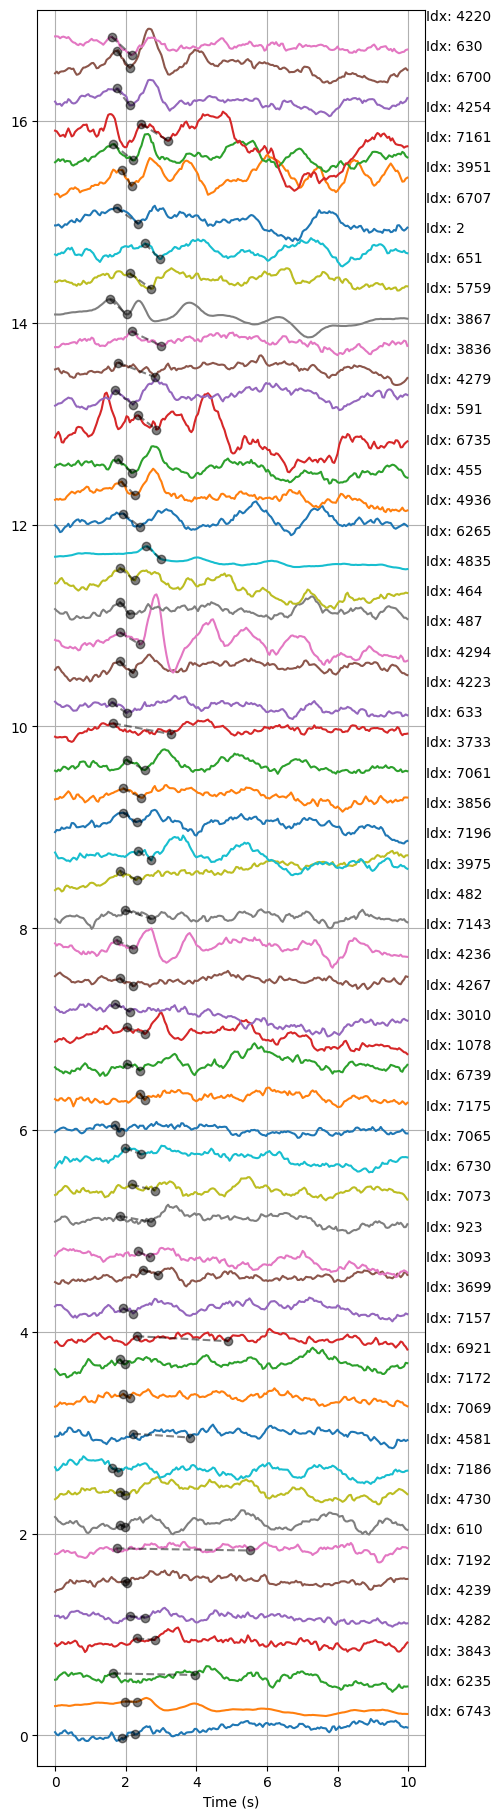

In [8]:
noise_80 = noise[noise['Level(dB)'] == 80]
subset = noise_80[noise_80['Amplitude'] < 0.2]
len(subset)

# plot waves, peaks, troughs:
plotted = []
n = 0
spacing=0.3
plt.figure(figsize=(5,len(subset)/5))
for idx, row in subset.sort_values('Amplitude').iterrows():
    if idx in plotted:
        continue

    plotted.append(idx)
    wave = row.Waveform
    time = np.linspace(0, 20, len(wave)) 
    wave = wave[time<=10]
    time = time[time<=10]
    pks = row.Peaks
    trs = row.Troughs
    
    plt.plot(time, wave+n)
    plt.plot(time[[pks[0], trs[0]]], wave[[pks[0], trs[0]]]+n, 'ko--', alpha=0.5)
    plt.text(10.5, n+0.2, f"Idx: {idx}")
#    plt.plot(time[trs[0]], wave[trs[0]]+n, 'go')
    n+=spacing

plt.xlabel('Time (s)')
plt.grid()    
plt.ylim(-spacing, n)
plt.show()


### Plot all data

<Axes: xlabel='Frequency(kHz)', ylabel='SynapsesPerIHC'>

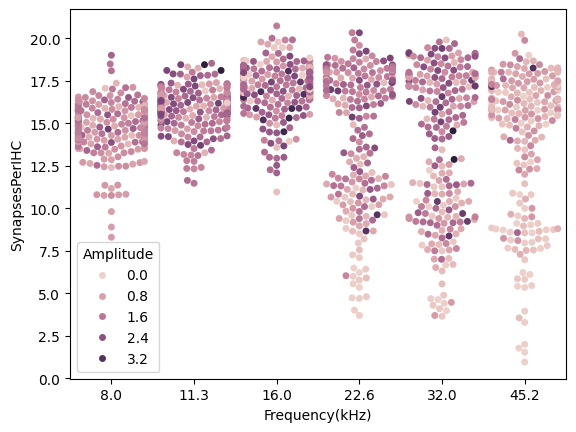

In [13]:
sns.swarmplot(data=final_clean_strained_80, x='Frequency(kHz)', y='SynapsesPerIHC', hue='Amplitude')

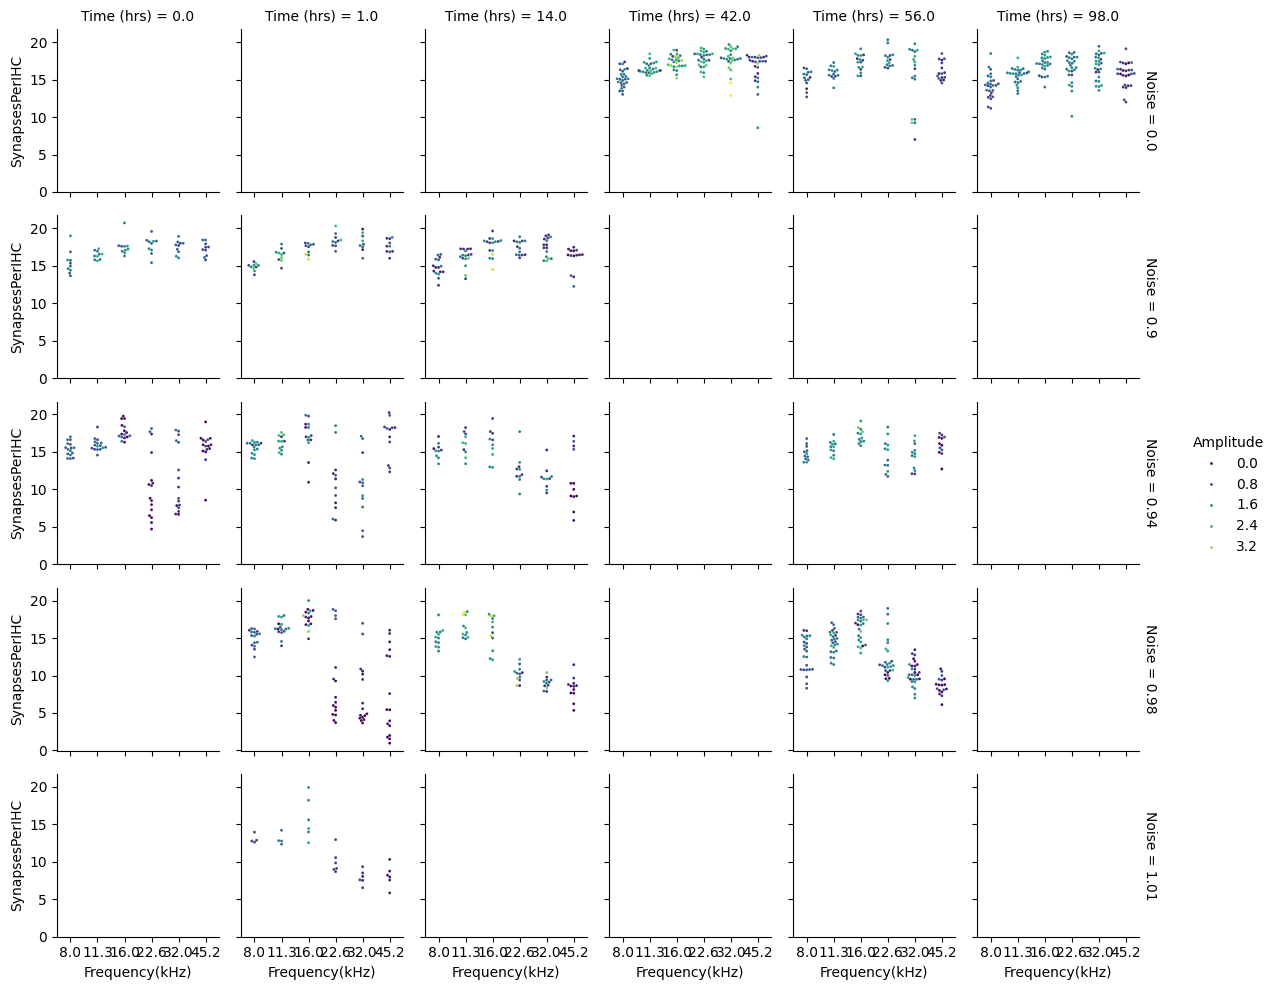

In [10]:
g = sns.catplot(data=final_clean_strained_80, kind="swarm", 
                height=2, aspect=1, margin_titles=True, #orient="h",
                col="Time (hrs)", row="Noise", 
                x="Frequency(kHz)", y="SynapsesPerIHC", 
                hue="Amplitude", palette="viridis", size=2,)
plt.show()

### V1 vs V2 similarity

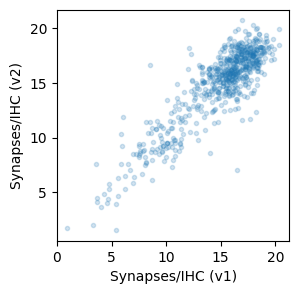

,Subject,Frequency(kHz),Level(dB),Amplitude,Strain,Group,SynapsesPerIHC_v1,SynapsesPerIHC_v2,Synapses to IHC DIFF
0,WPZ145,45.2,80.0,0.153990,C57B6,98dB 8wks post,8.750000,10.888889,-2.138889
1,WPZ145,8.0,80.0,0.896124,C57B6,98dB 8wks post,13.516484,14.470588,-0.954105
2,WPZ145,22.6,80.0,1.304017,C57B6,98dB 8wks post,11.320755,11.770833,-0.450079
3,WPZ145,11.3,80.0,1.344820,C57B6,98dB 8wks post,13.267327,15.777778,-2.510451
4,WPZ145,32.0,80.0,0.369373,C57B6,98dB 8wks post,13.444444,11.900000,1.544444


In [12]:
index_cols = ['Subject', 'Frequency(kHz)', 'Level(dB)', 'Amplitude','Strain', 'Group']

v1s = final_clean_strained_80[final_clean_strained_80['vx'] == 'v1'][index_cols+['SynapsesPerIHC']]
v2s = final_clean_strained_80[final_clean_strained_80['vx'] == 'v2'][index_cols+['SynapsesPerIHC']]


diff_reset = pd.merge(v1s, v2s, on=index_cols, suffixes=('_v1', '_v2'))
diff_reset['Synapses to IHC DIFF'] = diff_reset['SynapsesPerIHC_v1'] - diff_reset['SynapsesPerIHC_v2']
plt.figure(figsize=(3,3))
plt.plot(diff_reset['SynapsesPerIHC_v1'], diff_reset['SynapsesPerIHC_v2'], '.', alpha=0.2)
plt.xlabel('Synapses/IHC (v1)')
plt.ylabel('Synapses/IHC (v2)')
plt.show()

diff_reset.head()